In [3]:
# library imports
from importlib import reload
from copy import deepcopy
from Classes import ClusterObj, BlockObj, ScanDataObj
from Functions import CommonFunctions, ClassesFunctions
import pickle
import pandas as pd
import re
reload(CommonFunctions)
reload(ClassesFunctions)
reload(ClusterObj)
reload(BlockObj)
reload(ScanDataObj)

print('Done!')


Done!


In [4]:
# path setup
path = "/Users/afarinaqs/Library/CloudStorage/Box-Box/Home Folder aa714/Private/BME LAB/Afi/OOD Detection/Data/Ag Test"
input_file_name = '05062025_P0428_OF_first_slide_N5'
image, scaled_image = CommonFunctions.load_image(file_name=input_file_name, path=path, debug=False, plot_images=False, rotation=0)
# print(f'Loaded Image "{input_file_name}" {image.shape}')


In [5]:
# load the saved work, or start over:
scan_data = ClassesFunctions.read_scan_data_from_pickle(
    file_name=input_file_name,
    path=path,
    start_over=0, # if True -> ignores the pickle, and returns None for initiating with the following functions
    plot_results=False,
    debug=False
)

# scan_data = []
if not scan_data:
    start_over = True
else:
    print(f'Successfully loaded scan_data for "{input_file_name}"')
    start_over = False



No file with name 05062025_P0428_OF_first_slide_N5!
start_over is True


In [6]:
# todo: add a function for parameter tuning...
start_over

True

Successfully set the params for 05062025_P0428_OF_first_slide_N5 with these given keys: dict_keys(['scan_size', 'assay', 'cAb_names', 'blur_kernel_size', 'contrast_thr', 'canny_edge_thr1', 'canny_edge_thr2', 'dp', 'param1', 'param2', 'minRadius', 'maxRadius', 'eps', 'x_power', 'y_power', 'min_samples'])

 

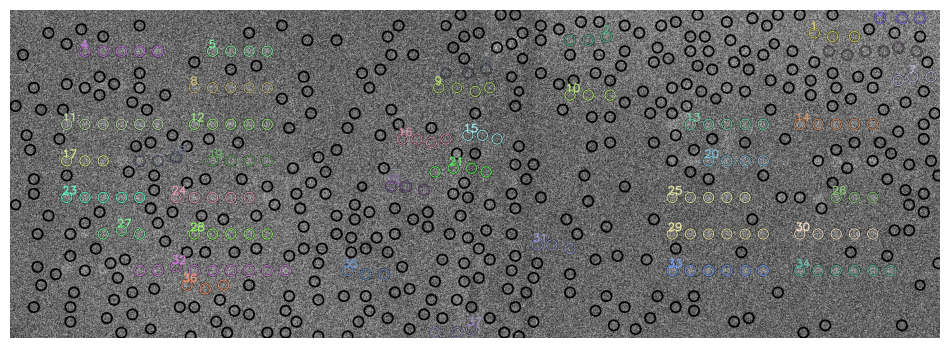

In [7]:
## Setting the parameters:
# start_over = True
do_test = 1
input_param_dict = {
    'scan_size': 5, 'assay': 'OF', 'cAb_names': [],
    'blur_kernel_size': 9, 'contrast_thr': 200, # preprocessing
    'canny_edge_thr1': 90, 'canny_edge_thr2': 290, 'dp': 10, 'param1': 11, 'param2':22, 'minRadius': 11, 'maxRadius': 18, # circle finding
    'eps':500, 'x_power': 3, 'y_power': 5, 'min_samples': 3 # clustering
}

# reset = True/False to overwrite start_over
if start_over:
    ScanDataObj.init_or_reset_params(file_name=input_file_name, input_param_dict=input_param_dict, debug=False)
    if do_test:
        if input_param_dict['assay'] == 'SD4':
            test_image = deepcopy(image)[1000:1700,500:2500] #(y,x) -> change if u want!
        else:
            test_image = deepcopy(image)[500:1400,50:2600]
        # checkme takes too long
        # CommonFunctions.optimize_the_params(file_name=input_file_name, input_image=test_image, how_many_times=1, plot_images=False, debug=False)
        CommonFunctions.test_current_parameters(input_image=test_image, file_name=input_file_name, fig_size=[12,7], debug=False)

In [ ]:
scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)

In [ ]:
# start_over=True
if start_over or not scan_data.sorted_circles:
    CommonFunctions.do_initial_circle_finding(file_name=input_file_name, debug=False, plot_images=False)
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
# else:
#     sorted_circles, predicted_clusters_ids = [],[]

In [ ]:
start_over = True
test_block_sizes = 1

if start_over:
    ClassesFunctions.init_blocks_dict(
        file_name=input_file_name, debug=False, plot_blocks=False,
        # debug_block_ids=['r0c0','r0c1','r0c2','r0c3'],
        init_offset=[0,0],
        block_size_adjustment=0,
        block_distance_adjustment=[0,-20],
    )
    if test_block_sizes:
        ClassesFunctions.plot_blocks_on_image(file_name=input_file_name, debug=False)
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [ ]:
# ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [ ]:
# start_over = True
if start_over:
    ClassesFunctions.init_clusters_dict(scan_data.sorted_circles, scan_data.predicted_clusters_ids, input_file_name,
                                        optimize_spots_coords=0, debug=0, debug_clusters_ids=[])
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [ ]:
# connect clusters and blocks (and final initiation stuff)
if start_over:
    ClassesFunctions.connect_clusters_to_blocks(file_name=input_file_name,debug=False,debug_clusters=[],debug_blocks=[],plot_images=False,)
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [ ]:
# test_block.__dict__

In [ ]:
# scan_data.get_cluster(838)

In [ ]:
## Making the first template of cluster patterns
start_over=True

test_ind = f'r0c0'
test_block: BlockObj.Block = scan_data.get_block(test_ind)
if not start_over:
    test_block.plot_block(fig_size=[6, 6], debug=False, with_border=True, crop_to_mask=True)
else:
    scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
    manual_spot_edit_dict = {
        13:['move spot-3 3 r','change_r spot-3 r+2']
    }
    print(test_block.clusters_ids_list)
    test_block.edit_block(debug=0, plot_before_after=False, overwrite=True,with_restore=True,
                          manual_spot_edit_dict=manual_spot_edit_dict)
    test_mask = test_block.create_block_mask(debug=False, plot_images=False)
    test_block.plot_block(fig_size=[8,8], debug=False, with_border=True, crop_to_mask=False)

N = len(test_block.clusters_ids_list)
print(f'There are {N} clusters in total.')


In [ ]:
# generating the list to edit each row at the same time
generate_list = lambda n: [f'r{n}c{i}' for i in range(scan_data.block_ncol)]
rows_names_list = []
for r in range(scan_data.block_nrow):
    rows_names_list.append(generate_list(r))


fig_size = [20,10] if scan_data.assay == 'SD4' else [15,15]
print(f'start_over is {start_over}')


In [ ]:
# ScanDataObj.get_block_image(
#             file_name=test_block.file_name,
#             block_id=test_block.block_id,
#             image_tag='block_mask'
#         )
plot_figures = False
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

In [ ]:
ScanDataObj.images_dict['05062025_P0428_OF_first_slide_N5'].keys()
print(ScanDataObj.images_dict['05062025_P0428_OF_first_slide_N5']['r3c2'].keys())
ScanDataObj.get_block_image(block_id='r0c0',file_name=input_file_name)
print(input_file_name)

In [ ]:
# row 0
r = 0
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={'r0c0':[0,0],'r0c1':[-10,-100],'r0c2':[0,0],'r0c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })

In [ ]:
## row 1
r = 1
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[-100,-50],f'r{r}c1':[0,0],f'r{r}c2':[0,0],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })

In [ ]:
# row 2
r = 2
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[0,0],f'r{r}c1':[0,0],f'r{r}c2':[0,0],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })

In [ ]:
# scan_data.get_block('r3c0').plot_block()

In [ ]:
# row 3
r = 3
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, do_plot=1)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[0,0],f'r{r}c1':[0,0],f'r{r}c2':[0,0],f'r{r}c3':[0,0]},
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })


In [ ]:
# row 4
r = 4
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[0,0],f'r{r}c1':[0,0],f'r{r}c2':[0,0],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })


In [ ]:
# row 5
r = 5
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0':[0,0],f'r{r}c1':[0,0],f'r{r}c2':[-45,10],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={381:['del']
        })


In [ ]:
# row 6
r = 6
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[0,0],f'r{r}c1':[0,0],f'r{r}c2':[0,0],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
             # 277:['del spot-1'], 276:['del spot-1'], 301:['del spot-1'], 308:['del spot-1'], 309:['del spot-1'], 287:['del spot-1'], 294:['del spot-1'], 300:['del spot-1'],
        })


In [ ]:
##### row 7
r = 7
current_list = rows_names_list[r]
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0':[0,0],f'r{r}c1':[0,5],f'r{r}c2':[-5,5],f'r{r}c3':[0,0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })


In [ ]:
##### row 8
r = 8
if scan_data.assay == 'SD4':
    current_list = rows_names_list[r]
else:
    current_list = []

print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0': [-50, 0], f'r{r}c1': [-50, 0], f'r{r}c2': [-50, 0], f'r{r}c3': [-50, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            386:['del'], 393:['del'], 402:['del'], 394:['del spot0'], 388:['move spot-1 10 r, 6 u']
        })


In [ ]:
##### row 9
r = 9
if scan_data.assay == 'SD4':
    current_list = rows_names_list[r]
else:
    current_list = print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0': [0, 0], f'r{r}c1': [0, 0], f'r{r}c2': [-2, 45], f'r{r}c3': [0, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
             403:['del'],
            # 404:['del spot6,4,2','move all 50 u'],
            404:['del'],
            420:['del'],
            405:['del'],
            # 409:['del'],
            # 411:['del spot0'],
            417:['del'],
        })


In [ ]:
##### row 10
r = 10
if scan_data.assay == 'SD4':
    current_list = rows_names_list[r]
else:
    current_list = []
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0': [-100, 0], f'r{r}c1': [-70, 0], f'r{r}c2': [-50, 0], f'r{r}c3': [-50, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })

In [ ]:
##### row 11
r = 11
if scan_data.assay == 'SD4':
    current_list = rows_names_list[r]
else:
    current_list = []
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        move_whole_block_match={f'r{r}c0': [0, 0], f'r{r}c1': [0, 0], f'r{r}c2': [0, 0], f'r{r}c3': [0, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
        })

In [ ]:
# b11 = scan_data.get_block('r11c0')
# # b11.reset_block_start_end_coords((200,9900), [1200,11000], debug=False)
# # b11.add_cropped_images()
# b11.plot_block()
# b11.__dict__

In [ ]:
##### row 12
r = 12
if scan_data.assay == 'SD4':
    current_list = rows_names_list[r]
else:
    current_list = []
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0': [-0, 0], f'r{r}c1': [-100, 0], f'r{r}c2': [-50, 0], f'r{r}c3': [-50, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            # 759:['del'],755:['add 1 cluster below d=50'], 761:['add 1 cluster above d=50'],
            555:['del']
        })


In [ ]:
##### row 13
r = 13
if scan_data.assay == 'SD4':
    current_list = rows_names_list[r]
else:
    current_list = []
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0': [-0, 0], f'r{r}c1': [-100, 0], f'r{r}c2': [-50, 0], f'r{r}c3': [-50, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            569:['del'], 567:['del spot3,2,1,0'], 581:['move spot-1 10 l']
        })


In [ ]:
##### row 14
r = 14
if scan_data.assay == 'SD4':
    current_list = rows_names_list[r]
else:
    current_list = []
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0': [-0, 0], f'r{r}c1': [-100, 0], f'r{r}c2': [-50, 0], f'r{r}c3': [-50, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            615:['del spot11,9,7,5,3,1,0']
        })


In [ ]:
# scan_data.get_block('r15c0').update_block_start_end_from_clusters_min_max()

In [ ]:
##### row 15
r = 15
if scan_data.assay == 'SD4':
    current_list = rows_names_list[r]
else:
    current_list = []
print(current_list)

# start_over = True

if not start_over:
    # ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    ClassesFunctions.do_final_results_plot(file_name=input_file_name, block_ids_list=current_list, fig_size=fig_size, do_plot=plot_figures)

else:
    ClassesFunctions.edit_multiple_blocks(
        current_list, file_name=input_file_name, init_template_id=test_ind, correct_N=N,
        debug=0, debug_blocks=[''], debug_clusters=[], fig_size=fig_size,
        # move_whole_block_match={f'r{r}c0': [-50, -100], f'r{r}c1': [0, -10], f'r{r}c2': [0, 0], f'r{r}c3': [0, 0]},
        # redo_circle_finding_for_blocks_or_clusters=['r0c3'],
        preprocess_params=scan_data.preprocess_params, plot_before_after=0,
        manual_spot_edit_dict={
            # 780:['del spot11,9,7,5,3,1,0']
        })


In [ ]:
path, input_file_name

In [ ]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)


In [ ]:
## Additional test info and labeling
scan_data = ScanDataObj.get_scan_data(file_name=input_file_name)
scan_data.cAb_names = ['JN','OX','EG','gamma','Delta_o','Beta_o','BA','kappa','Omicron_o','Eta','Omicron','Delta','WT','Beta'] # row by row, left to right

# # assuming scan_data.assay =='SD4':
# curve_num_points = 7
# num_rep = 3
# num_blank_rows_at_bottom = 1
#
# start_Ag_conc = 1024
# dilution_factor = 2

# if curve_num_points == 4:
#     rows_info = {
#         'r0,2,4,6': {'Ag': 'WT'},
#         'r1,3,5,7': {'Ag': 'WT'},
#         'r8,10,12,14': {'Ag': 'Omicron'},
#         'r9,11,13,15': {'Ag': 'Omicron'},
#     }
#     cols_info = {
#         'col0': {'dAb': '34@1.5'},
#         'col1': {'dAb': '35@1.5'},
#         'col2': {'dAb': '34@1'},
#         'col3': {'dAb': '35@1'},
#     }
# else:
#     rows_info, cols_info = {}, {}
#
# #------
# blocks_info = {}
# for rows_ids, ag_dict in rows_info.items():
#     r_list = [int(x) for x in re.findall(r'\d+', rows_ids)]
#     if len(r_list) != curve_num_points:
#         print('WTF!!!')
#
#     for col, dAb_dict in cols_info.items():
#         c = int(re.findall(r'\d+', col)[0])
#
#         point_counter = 0
#         for r in r_list:
#             block_id = f'r{r}c{c}'
#             block = scan_data.get_block(block_id)
#             block.dAb_label = dAb_dict['dAb']
#             block.target = ag_dict['Ag']
#             block.Ag_conc = start_Ag_conc / (dilution_factor ** point_counter)
#             block.add_names_to_clusters(debug=1)
#             print(f'{block.block_id} - {block.target}@{block.Ag_conc} - {block.dAb_label}')
#             point_counter += 1

# screening Ags with secondary antibodies
curve_num_points = 7
num_rep = 3
num_blank_rows_at_bottom = 1

for r in range(8):
    if r == 0:
        dAb_label = 'COV2_SEC2'
    elif r == 1:
        dAb_label = 'COV2_SEC1'
    elif r == 2:
        dAb_label = 'COV1.5_SEC2'
    elif r == 3:
        dAb_label = 'COV1.5_SEC1'
    elif r == 4:
        dAb_label = 'COV1_SEC2'
    elif r == 5:
        dAb_label = 'COV1_SEC1'
    elif r == 6:
        dAb_label = 'COV0.75_SEC2'
    elif r == 7:
        dAb_label = 'COV0_SEC2'

    for c in range(3):
        block_id = f'r{r}c{c}'
        block = scan_data.get_block(block_id)
        block.dAb_label = dAb_label
        block.target = ''
        block.Ag_conc = 500
        block.add_names_to_clusters(debug=0)
        print(f'{block.block_id} - {block.target}@{block.Ag_conc} - {block.dAb_label}')


# def add_labels(assay_info_dict,debug=False):
#     blank_rows = [scan_data.block_nrow - x - 1 for x in range(num_blank_rows_at_bottom)]
#     CommonFunctions.debug_report(f'blank_rows are {blank_rows}',debug)
#     for start_block_id, cond_dict in assay_info_dict.items():
#         start_block = scan_data.get_block(start_block_id)
#
#         for n in range(1,curve_num_points):
#             new_r = start_block.row_number + n
#             new_block = scan_data.get_block(f'r{new_r}c{start_block.col_number}')
#             new_block.dAb_label = cond_dict['dAb']
#             new_block.target = cond_dict['Ag']
#             new_block.Ag_conc = start_Ag_conc / dilution_factor ** n if new_r not in blank_rows else 0
#             new_block.add_names_to_clusters(debug=debug)
#             print(f'\t{new_block.block_id} - {new_block.target}@{new_block.Ag_conc}')
#
# add_labels(assay_info_dict=assay_info, debug=0)



In [ ]:
scan_data.get_block('r0c0').plot_block(description='full_report')


In [ ]:
# ClassesFunctions.save_dicts_in_pickle(path=path)

In [ ]:
# scan_data.get_block('r0c0').full_report()
# print(scan_data.get_block('r0c0').full_report(return_str=1))
# scan_data.get_block('r1c0').plot_block(description='cAb_names')

In [ ]:
out_dfs = []
sigma1 = 2
sigma2 = 1.7

# this one goes row by row:
for r in range(scan_data.block_nrow):
    block_ids_list = rows_names_list[r]
    out_df, counts = ClassesFunctions.measure_signal_of_blocks(
        block_ids_list=block_ids_list,
        file_name=input_file_name,
        sigma1=sigma1,
        sigma2=sigma2,
        fg_inc_pixels=1,
        margin_pixels=3,
        bg_r=6,
        debug=0,
        debug_blocks_ids=[''],
        plot_images=0,
    )
    out_dfs.append(out_df)
#     total_counts += counts1



In [ ]:
path

In [ ]:
# wanna see everything for Z in rXcY:
cAb = 'Delta_0'
row_id = 0
block_id = f'r{row_id}c0'
df1 = out_dfs[row_id]
df = df1[(df1['cAb_name']==cAb) & (df1['Block_ID']==block_id)]
scan_data.get_block(block_id).plot_block(description='full_report', crop_to_mask=1)
# print(df)
df1

In [ ]:
# formated_path

In [ ]:
dosave=True
formated_path = f'{path}/{input_file_name}_genepix_level'

if dosave:
    ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)
    intensities_df = pd.concat(out_dfs, ignore_index=True)
    with open(formated_path+'.pickle', 'wb') as file:
        pickle.dump(intensities_df, file)

    intensities_writer = pd.ExcelWriter(formated_path + '.xlsx')
    intensities_df.to_excel(intensities_writer, index=True)
    intensities_writer.close()


    print(f'saved intensities_df {intensities_df.shape}.')

else:
    with open(formated_path+'.pickle', 'rb') as file:
        intensities_df = pickle.load(file)
        print(f'loaded intensities_df {intensities_df.shape}')


intensities_df

In [ ]:
intensities_df[intensities_df['cAb_name']=='JN']

In [ ]:
scan_data.get_block('r0c0').plot_block(description='full_report', fig_size=[10,10])


In [ ]:
ag_test = 1
grouped = intensities_df.groupby(['Block_ID', 'Row', 'Col', 'cAb_name', 'dAb_name'])['Average_F_B_PostProcess'].mean().reset_index()
grouped = grouped.sort_values(by=['Row', 'Col'])
grouped['abs_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}" +
                                           ("" if x['Col'] == 0 else "_1" if x['Col'] == 1 else "_2"), axis=1)

grouped[['COV_Ab', 'SEC_Ab']] = grouped['dAb_name'].str.extract(r'([^_]+)_([^_]+)')

grouped[grouped['cAb_name']=='JN']
# grouped.columns



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

ags = sorted(grouped['cAb_name'].unique())
n_rows, n_cols = 3, 5

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3), constrained_layout=True)

for ax, ag_val in zip(axes.flat, ags):
    subset = grouped[grouped['cAb_name'] == ag_val]
    pivot = subset.groupby(['COV_Ab', 'SEC_Ab'])['Average_F_B_PostProcess'].mean().unstack()/1000

    sns.heatmap(pivot, annot=True, cmap='crest',ax=ax, cbar=False)
    ax.set_title(f'Ag: {ag_val}')
    ax.set_xlabel('SEC_Ab')
    ax.set_ylabel('COV_Ab')

# Hide unused subplots if there are any
for ax in axes.flat[len(ags):]:
    ax.axis('off')

plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

pivot = grouped.groupby(['COV_Ab', 'SEC_Ab'])['Average_F_B_PostProcess'].mean().unstack()/1000

plt.figure(figsize=(3,4))
sns.heatmap(pivot, annot=True, cmap="viridis")
plt.title(f'Avg Heatmap')
plt.xlabel('SEC_Ab')
plt.ylabel('COV_Ab')
plt.tight_layout()
plt.show()



In [ ]:
sheets_df = {}
for Ag, group in grouped.groupby('cAb_name'):
    print(Ag)
    sheet_name = f"{Ag}"
    filtered_group = group.copy()
    # print(filtered_group.columns)
    unique_reps = sorted(filtered_group['abs_rep'].unique())
    # print(f'unique_reps: {unique_reps}')
    filtered_group = filtered_group[filtered_group['abs_rep'].isin(unique_reps)]
    filtered_group.insert(0, 'Label', sheet_name)
    pivot_df = filtered_group.pivot_table(index=['Label'], columns=['abs_rep'],
                                 values='Average_F_B_PostProcess').sort_values(by=['Label'],ascending=False)
    pivot_df.reset_index(inplace=True)
    sheets_df[sheet_name] = pivot_df

sheets_df['JN']

In [ ]:
grouped = intensities_df.groupby(['Ag_Conc.', 'Block_ID', 'Row', 'Col', 'target', 'cAb_name', 'dAb_name'])['Average_F_B_PostProcess'].mean().reset_index()
grouped = grouped.sort_values(by=['Row', 'Col'])

if num_rep == 2 and curve_num_points==4:
    grouped['dAb_cAb_rep'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}" +
                                           ("" if x['Row'] % 2 == 0 else "_2"), axis=1)
# if ag_test:
#     grouped['ab_pair'] = grouped.apply(lambda x: f"{x['dAb_name']}_{x['cAb_name']}" +
#                                            ("" if x['Row'] % 2 == 0 else "_2"), axis=1)


grouped[grouped['cAb_name']=='JN']['dAb_cAb_rep']



In [ ]:
grouped.groupby(['dAb_name', 'target']).head()

In [ ]:
sheets_df = {}
for (dAb, target), group in grouped.groupby(['dAb_name', 'target']):
    sheet_name = f"{dAb}_{target}"
    filtered_group = group.copy()
    print(filtered_group.columns)
    unique_reps = sorted(filtered_group['dAb_cAb_rep'].unique())
    filtered_group = filtered_group[filtered_group['dAb_cAb_rep'].isin(unique_reps)]
    filtered_group.insert(0, 'Label', sheet_name)
    pivot_df = filtered_group.pivot_table(index=['Label','Ag_Conc.'], columns=['dAb_cAb_rep'],
                                 values='Average_F_B_PostProcess').sort_values(by=['Label','Ag_Conc.'],ascending=False)
    pivot_df.reset_index(inplace=True)
    sheets_df[sheet_name] = pivot_df

sheets_df['34@1.5_WT']

In [ ]:
ClassesFunctions.save_current_data_obj(file_name=input_file_name, path=path)

formated_path = f'{path}/{input_file_name}_summary'
summary_writer = pd.ExcelWriter(formated_path + '.xlsx')

for sheet_name, sheet_df in sheets_df.items():
    sheet_df.to_excel(summary_writer, sheet_name=sheet_name, index=False)
summary_writer.close()

with open(formated_path+'.pickle', 'wb') as file:
    pickle.dump(sheets_df, file)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_dose_response_with_error(results_df):
    # Extract base names by removing "_2" suffix if present
    results_df['base_dAb_cAb_rep'] = results_df['dAb_cAb_rep'].str.replace('_2$', '', regex=True)

    # Group by target, Ag_Conc., and base_dAb_cAb_rep to compute mean and std
    grouped_df = results_df.groupby(['target', 'Ag_Conc.', 'base_dAb_cAb_rep'])['Average_F_B_PostProcess'].agg(['mean', 'std']).reset_index()

    # Plot each unique target
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=grouped_df, x='Ag_Conc.', y='mean', hue='base_dAb_cAb_rep', style='target', marker='o')
    plt.errorbar(grouped_df['Ag_Conc.'], grouped_df['mean'], yerr=grouped_df['std'], fmt='o', alpha=0.5)

    plt.xscale('log')  # Log scale if needed
    plt.xlabel("Antigen Concentration")
    plt.ylabel("Response (Fluorescence)")
    plt.title("Dose-Response Curves with Error Bars")
    plt.legend(title="dAb_cAb_rep")
    plt.show()

# Example usage:
plot_dose_response_with_error(group)


In [ ]:
group